In [1]:
# System
import os
# Numpy
import numpy as np
# Dataframe
import pandas as pd
# Type hints
from typing import Union
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
# Datetime
import datetime as dt 
# Technical analysis tool
import talib
# Get market data
import pandas_datareader.data as web
# Statistics
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
# Base classes for estimators
from sklearn.base import (BaseEstimator, TransformerMixin,
                          ClassifierMixin, RegressorMixin)
# Cross-validation
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
# Preprocessing
from sklearn.preprocessing import StandardScaler, QuantileTransformer, quantile_transform
from sklearn.decomposition import PCA
# Transformers
from sklearn.compose import make_column_transformer
# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
# Feature selection
from sklearn.feature_selection import f_regression, SelectKBest
# Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor,
                              VotingRegressor, GradientBoostingRegressor)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
# Metrics
from sklearn.metrics import (make_scorer, 
            mean_squared_error, mean_absolute_error, r2_score)

In [2]:
# Seed
seed = 42

# set plots size
plt.rcParams['figure.figsize'] = (10, 4)

In [3]:
# Set date ranges:
## Start date
start = dt.datetime(2018,1,1)
## End date
end = dt.datetime(2020,8,1)

# Set symbol name
symbol_name = '^GSPC' #SP500

In [4]:
# Import data using Pandas Datareader
def get_data(symbol_name, start, end, data_source='yahoo'):
    df = web.DataReader(
            name = symbol_name, data_source = data_source, 
            start = start, end = end
        )
    return df

In [5]:
# Get data
df = get_data(symbol_name, start, end)

In [6]:
# Print prices of selected stock for start and end date
print(pd.concat([df.head(1), df.tail(1)]))

                   High          Low         Open        Close      Volume  \
Date                                                                         
2018-01-02  2695.889893  2682.360107  2683.729980  2695.810059  3367250000   
2020-07-31  3272.169922  3220.260010  3270.449951  3271.120117  5117260000   

              Adj Close  
Date                     
2018-01-02  2695.810059  
2020-07-31  3271.120117  


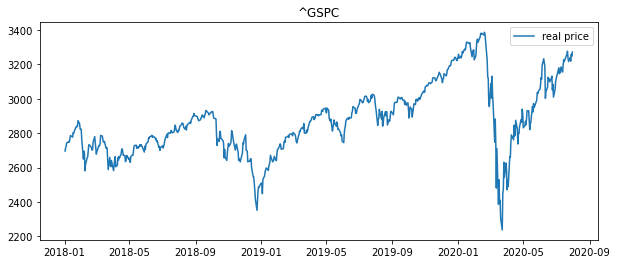

In [7]:
# Plot historical price data
plt.figure(figsize=(10,4))
plt.title(symbol_name)
plt.plot(df['Close'], label='real price')
plt.legend()
plt.show()

# Feature Engineering

### Percent Change 

In [8]:
class PercentChange(BaseEstimator, TransformerMixin):
    """Percent change of data.

    Attributes:
        column(str): Column name for calculation
        pct_periods(int): Periods to shift for forming percent change
    
    Methods:
        transform(X): Returns data percent change

    Returns:
        Dictionary.
    """
    def __init__(self, column: str, pct_periods: int):
        self.column = column
        self.pct_periods = pct_periods

    def fit( self, X: Union[pd.DataFrame, dict], y = None):
        return self        

    def transform(self, X: Union[pd.DataFrame, dict], y = None) -> dict:
        """Percent change.
        Arguments:
            X(pandas.dataframe,dict): df/dict with column(s) to calculate pct change.
        """
        features = {}
        features = X[self.column].pct_change(self.pct_periods)
        return features

In [9]:
### Difference of element

In [10]:
class DiffChange(BaseEstimator, TransformerMixin):
    """Calculates the difference of a Dataframe element.

    Attributes:
        colname(list/str): Column name for calculating difference
        diff_periods(int): Periods to shift for calculating difference, 
                            accepts negative values
    
    Methods:
        transform(X): Returns price change

    Returns:
        Dictionary/DataFrame.
    """
    def __init__(self, colname: str, diff_periods: int=1):
        self.colname = colname
        self.diff_periods = diff_periods

    def fit( self, X: Union[pd.DataFrame, dict], y = None):
        return self     

    def transform(self, X: Union[pd.DataFrame, dict], y = None) -> dict:
        """Calculates the difference of a Dataframe element.
        Arguments:
            X(pandas.dataframe,dict): df/dict with target columns
        """
        features = {}
        features = X[self.colname].diff(self.diff_periods)
        return features

### Daily Returns

In [12]:
class DailyReturn(BaseEstimator, TransformerMixin):
    """Daily return.
    
    Attributes:
        close(str): Column name for closing price.
        open(str): Column name for opening price.

    Methods:
        transform(X): Daily return

    Returns:
        Dictionary.
    """
    def __init__(self, close: str, open: str):
        self.close = close
        self.open = open

    def fit( self, X: Union[pd.DataFrame, dict], y = None):
        return self 

    def transform(self, X: Union[pd.DataFrame, dict], y = None) -> dict:
        """Daily return.
        Arguments:
            X(pandas.dataframe,dict): df/dict with daily return columns
        """
        features = {}
        features = X[self.close]/X[self.open]-1
        return features